In [42]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [43]:
def price_plot(df, column_name, plot_trend = False):
    price = df["Price"]
    data = df[column_name]
    plt.plot(data,price, 'o')
    plt.xlabel(column_name)
    plt.ylabel("Price_PLN")
    if plot_trend:
        z = np.polyfit(data, price, 1)
        p = np.poly1d(z)
        print(f"Polyfit equation: {p}")
        plt.plot(data, p(data))
    plt.axvline(data.mean(), color="red")
    plt.axhline(price.mean(), color="red")


# Loading data

In [44]:
df = pd.read_csv("data/Car_sale_ads.csv")
list(df.columns)
df.head()

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.0,...,Manual,coupe,2.0,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.0,...,Automatic,small_cars,3.0,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."
3,3,39900,PLN,Used,Abarth,500,NaN,NaN,2012,29000.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,30/04/2021,"Jaworzno, Śląskie","['ABS', 'Electric front windows', 'Drivers air..."
4,4,97900,PLN,New,Abarth,595,NaN,NaN,2021,600.0,...,Manual,small_cars,3.0,blue,NaN,NaN,NaN,30/04/2021,"ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...","['ABS', 'Electrically adjustable mirrors', 'Pa..."


**Context:**<br>
This dataset was created by webscraping over 200,000 car offers from one of the largest car advertisement sites in Poland.<br>
<br>

**Content:**<br>
The dataset contains 208,304 observations of 25 variables.<br>
<br>

**Variables describtion:**<br>
ID - unique ID of offer <br>
Price - value of the price <br>
Currency - currency of the price (mostly polish złoty, but also some euro)<br>
Condition - new or used<br>
Vehicle_brand - brand of vehicle in offer<br>
Vehicle_model - model of vehicle in offer<br>
Vehicle_generation - generation of vehicle in offer<br>
Vehicle_version - version of vehicle in offer<br>
Production_year - year of car production<br>
Mileage_km - total distance that the car has driven in kilometers<br>
Power_HP - car engine power in horsepower<br>
Displacement_cm3 - car engine size in cubic centimeters<br>
Fuel_type - car fuel type<br>
CO2_emissions - car CO2 emissions in g/km<br>
Drive - type of car drive<br>
Transmission - type of car transmission<br>
Type - car body style<br>
Doors_number - number of car doors<br>
Colour - car body color<br>
Origin_country - country of origin of the car<br>
First_owner - whether the owner is the first owner<br>
First_registration_date - date of first registration<br>
Offer_publication_date - date of publication of the offer<br>
Offer_location - address provided by the issuer<br>
Features - listed car features (ABS, airbag, parking sensors e.t.c)<br>

# Data preprocessing

### Unification of the price currency and selection of the desired columns

In [45]:
price = df["Price"].copy()
currency = df["Currency"].copy()

for idx, (p, c) in enumerate(zip(price, currency)):
    if c == "EUR":
        price_PLN = p * 4.6
        price[idx] = price_PLN
        currency[idx] = "PLN"


df["Currency"] = currency
df["Price"] = price

cols2add = ["Price", "Vehicle_brand", "Vehicle_model", "Production_year", "Mileage_km", "Power_HP", "Displacement_cm3"]
test_df = df[cols2add]
test_df.head()

,Price,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3
0,86200.0,Abarth,595,2021,1.0,145.0,1400.0
1,43500.0,Abarth,Other,1974,59000.0,75.0,1100.0
2,44900.0,Abarth,500,2018,52000.0,180.0,1368.0
3,39900.0,Abarth,500,2012,29000.0,160.0,1368.0
4,97900.0,Abarth,595,2021,600.0,165.0,1368.0


Due to the extensive size of the dataset and the wide range of car models included, we have made the decision to conduct our analysis solely on a single car model.<br>
***Chosen car model:***<br>
**Brand:** Audi <br>
**Model:** A3<br>

In [46]:
audi_cars = test_df[test_df['Vehicle_brand'] == "Audi"]
audi_a3_cars = audi_cars[audi_cars["Vehicle_model"] == 'A3']

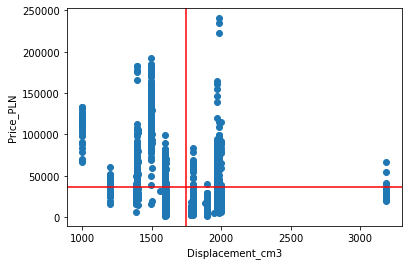

In [47]:
price_plot(audi_a3_cars,"Displacement_cm3")

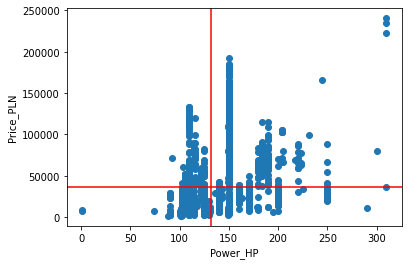

In [48]:
price_plot(audi_a3_cars,"Power_HP")

In [49]:
correlations = audi_a3_cars.iloc[:, 1:].corrwith(audi_a3_cars['Price'])
print(correlations)

Production_year     0.853472
Mileage_km         -0.764658
Power_HP            0.354174
Displacement_cm3   -0.301169
dtype: float64


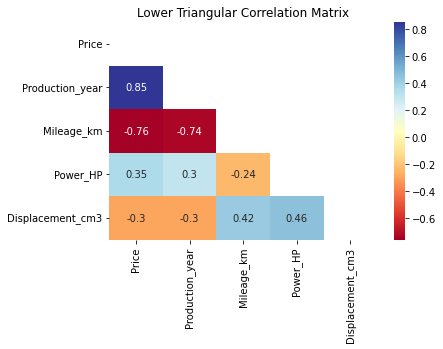

In [50]:
correlation_matrix = audi_a3_cars.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, mask=mask, annot=True, cmap='RdYlBu')
plt.title('Lower Triangular Correlation Matrix')
plt.show()

Due to small effect of engine power and displacement on the price of a vehicle, it was decided that only cars with a displacement of 2000ccm would be analysed to simplify analizis.

In [51]:
audi_a3_2010 = audi_a3_cars[audi_a3_cars["Production_year"] == 2010]
audi_a3_2000ccm = audi_a3_cars[audi_a3_cars["Displacement_cm3"] >= 1950]
audi_a3_2000ccm = audi_a3_2000ccm[audi_a3_2000ccm["Displacement_cm3"] <= 2050]
audi_a3_2000ccm = audi_a3_2000ccm.dropna()

In [52]:
if "audi_cars_data.csv" not in os.listdir("data"):
    audi_a3_2000ccm.to_csv('data/audi_cars_data.csv', index=False)

### Summary

In [53]:
audi_a3_2000ccm.head()

,Price,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3
1929,49900.0,Audi,A3,2015,208000.0,150.0,1968.0
1932,13900.0,Audi,A3,2008,227000.0,140.0,1968.0
1933,21900.0,Audi,A3,2008,313855.0,140.0,1968.0
1934,19900.0,Audi,A3,2007,242000.0,170.0,1968.0
1936,22900.0,Audi,A3,2006,240000.0,200.0,1984.0


Polyfit equation:  
4988 x - 9.99e+06


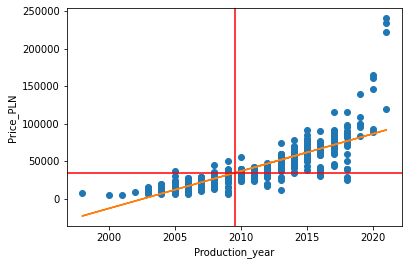

In [54]:
price_plot(audi_a3_2000ccm, "Production_year", True)

Polyfit equation:  
-0.2344 x + 8.109e+04


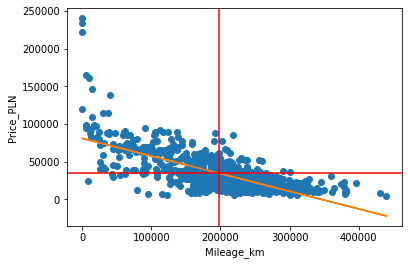

In [55]:
price_plot(audi_a3_2000ccm, "Mileage_km", True)

Polyfit equation:  
487.6 x - 4.072e+04


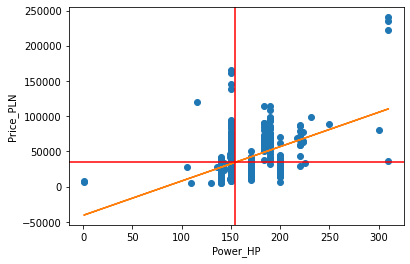

In [56]:
price_plot(audi_a3_2000ccm, "Power_HP", True)

Mean: 198361.37403598972


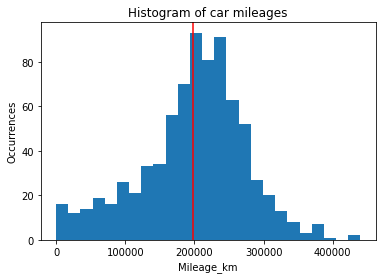

In [57]:
mileage_mean = np.mean(audi_a3_2000ccm["Mileage_km"])
print(f"Mean: {mileage_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Mileage_km"], bins = 25)
plt.axvline(mileage_mean, color="red")
plt.xlabel("Mileage_km")
plt.ylabel("Occurrences")
plt.title("Histogram of car mileages")
plt.show()

Mean: 2009.5719794344473


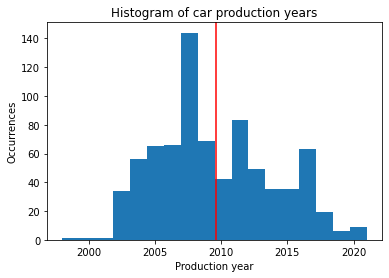

In [58]:
prod_mean = np.mean(audi_a3_2000ccm["Production_year"])
print(f"Mean: {prod_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Production_year"], bins = 18)
plt.axvline(prod_mean, color="red")
plt.xlabel("Production year")
plt.ylabel("Occurrences")
plt.title("Histogram of car production years")
plt.show()

Mean: 34600.235218509


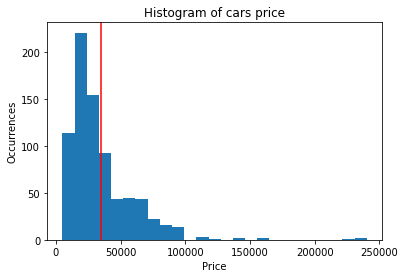

In [59]:
price_mean = np.mean(audi_a3_2000ccm["Price"])
print(f"Mean: {price_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Price"], bins = 25)
plt.axvline(price_mean, color="red")
plt.xlabel("Price")
plt.ylabel("Occurrences")
plt.title("Histogram of cars price")
plt.show()